## Semi-Lagrangian method

Let us consider an abstract scalar advection equation of the form
$$
\frac{\partial f}{\partial t}+ a(x, t) \cdot \nabla f = 0. 
$$
The characteristic curves associated to this equation are the solutions of the ordinary differential equations
$$
\frac{dX}{dt} = a(X(t), t)
$$
We shall denote by $X(t, x, s)$ the unique solution of this equation associated to the initial condition $X(s) = x$.

The classical semi-Lagrangian method is based on a backtracking of characteristics. Two steps are needed to update the distribution function $f^{n+1}$ at $t^{n+1}$ from its value $f^n$ at time $t^n$ :
1. For each grid point $x_i$ compute $X(t^n; x_i, t^{n+1})$ the value of the characteristic at $t^n$ which takes the value $x_i$ at $t^{n+1}$.
2. As the distribution solution of first equation verifies 
$$f^{n+1}(x_i) = f^n(X(t^n; x_i, t^{n+1})),$$
we obtain the desired value of $f^{n+1}(x_i)$ by computing $f^n(X(t^n;x_i,t^{n+1})$ by interpolation as $X(t^n; x_i, t^{n+1})$ is in general not a grid point.

*[Eric Sonnendrücker - Numerical methods for the Vlasov equations](http://www-m16.ma.tum.de/foswiki/pub/M16/Allgemeines/NumMethVlasov/Num-Meth-Vlasov-Notes.pdf)*

In [2]:
using Plots, FFTW, LinearAlgebra, Statistics, BenchmarkTools

## Bspline



In [3]:
"""
    bspline(p, j, x)

Return the value at x in [0,1[ of the B-spline with integer nodes of degree p with support starting at j.
Implemented recursively using the [De Boor's Algorithm](https://en.wikipedia.org/wiki/De_Boor%27s_algorithm)

```math
B_{i,0}(x) := \\left\\{
\\begin{matrix}
1 & \\mathrm{if}  \\quad t_i ≤ x < t_{i+1} \\\\
0 & \\mathrm{otherwise} 
\\end{matrix}
\\right.
```

```math
B_{i,p}(x) := \\frac{x - t_i}{t_{i+p} - t_i} B_{i,p-1}(x) 
+ \\frac{t_{i+p+1} - x}{t_{i+p+1} - t_{i+1}} B_{i+1,p-1}(x).
```
"""
function bspline(p::Int, j::Int, x::Float64)
   if p == 0
       if j == 0
           return 1.0
       else
           return 0.0
       end
   else
       w = (x - j) / p
       w1 = (x - j - 1) / p
   end
   return (w * bspline(p - 1, j, x) + (1 - w1) * bspline(p - 1, j + 1, x))
end

bspline

In [4]:
?bspline

search: bspline



```
bspline(p, j, x)
```

Return the value at x in [0,1[ of the B-spline with integer nodes of degree p with support starting at j. Implemented recursively using the [De Boor's Algorithm](https://en.wikipedia.org/wiki/De_Boor%27s_algorithm)

$$
B_{i,0}(x) := \left\{
\begin{matrix}
1 & \mathrm{if}  \quad t_i ≤ x < t_{i+1} \\
0 & \mathrm{otherwise} 
\end{matrix}
\right.
$$

$$
B_{i,p}(x) := \frac{x - t_i}{t_{i+p} - t_i} B_{i,p-1}(x) 
+ \frac{t_{i+p+1} - x}{t_{i+p+1} - t_{i+1}} B_{i+1,p-1}(x).
$$


In [5]:
"""
    UniformMesh(xmin, xmax, nx)

1D uniform mesh data
"""
struct UniformMesh
   xmin  :: Float64
   xmax  :: Float64
   nx    :: Int
   dx    :: Float64
   x     :: Vector{Float64}
   function UniformMesh(xmin, xmax, nx)
      dx = (xmax - xmin) / nx
      x  = range(xmin, stop=xmax, length=nx+1)[1:end-1]     
      new( xmin, xmax, nx, dx, x)
   end
end

UniformMesh

In [6]:
mesh = UniformMesh(-π, π, 10)
mesh.dx, mesh.nx

(0.6283185307179586, 10)

In [7]:
"""
    advection!(f, p, mesh, v, dt)

function to advect the distribution function `f` with velocity `v`
during a time step `dt`. Interpolation method uses bspline periodic.
"""
function advection!(f    :: Array{Complex{Float64},2}, 
                    p    :: Int64, 
                    mesh :: UniformMesh, 
                    v    :: Vector{Float64}, 
                    dt   :: Float64)
    
   nx = mesh.nx
   nv = length(v)
   dx = mesh.dx
   modes = [2π * i / nx for i in 0:nx-1]
    
   # compute eigenvalues of degree p b-spline matrix
   eig_bspl  = zeros(Float64, nx)
   eig_bspl .= bspline(p, -div(p+1,2), 0.0)
   for i in 1:div(p+1,2)-1
      eig_bspl .+= bspline(p, i - (p+1)÷2, 0.0) * 2 .* cos.(i * modes)
   end
   eigalpha = zeros(Complex{Float64}, nx)
    
   fft!(f,1)
    
   for j in 1:nv
      @inbounds alpha = dt * v[j] / dx
      # compute eigenvalues of cubic splines evaluated at displaced points
      ishift = floor(-alpha)
      beta   = -ishift - alpha
      fill!(eigalpha,0.0im)
      for i in -div(p-1,2):div(p+1,2)
         eigalpha .+= (bspline(p, i-div(p+1,2), beta) 
                        .* exp.((ishift+i) * 1im .* modes))
      end
          
      # compute interpolating spline using fft and properties of circulant matrices
      
      @inbounds f[:,j] .*= eigalpha ./ eig_bspl
        
   end
        
   ifft!(f,1)
    
end            

advection!

# Vlasov-Poisson equation
We consider the dimensionless Vlasov-Poisson equation for one species
with a neutralizing background.

$$ 
\frac{\partial f}{\partial t}+ v\cdot \nabla_x f + E(t,x) \cdot \nabla_v f = 0, \\
- \Delta \phi = 1 - \rho, E = - \nabla \phi \\
\rho(t,x)  =  \int f(t,x,v)dv.
$$

- [Vlasov Equation - Wikipedia](https://en.wikipedia.org/wiki/Vlasov_equation)

In [23]:
"""
    compute_rho(meshv, f)

Compute charge density
ρ(x,t) = ∫ f(x,v,t) dv
"""
function compute_rho(meshv::UniformMesh, 
        f::Array{Complex{Float64},2})
    
   dv = meshv.dx
   rho = dv * sum(real(f), dims=2)
   vec(rho .- mean(rho)) # vec squeezes the 2d array returned by sum function
end

compute_rho

In [24]:
"""
    compute_e(meshx, rho)
compute Ex using that -ik*Ex = rho 
"""
function compute_e(meshx::UniformMesh, rho::Vector{Float64})
   nx = meshx.nx
   k =  2π / (meshx.xmax - meshx.xmin)
   modes = zeros(Float64, nx)
   modes .= k * vcat(0:div(nx,2)-1,-div(nx,2):-1)
   modes[1] = 1.0
   rhok = fft(rho)./modes
   rhok .*= -1im
   ifft!(rhok)
   real(rhok)
end

compute_e

# Landau Damping

[Landau damping - Wikipedia](https://en.wikipedia.org/wiki/Landau_damping)

In [25]:
function landau( ϵ, kx, meshx, meshv)
    nx = meshx.nx
    nv = meshv.nx
    x  = meshx.x
    v  = meshv.x
    f  = zeros(Complex{Float64},(nx,nv))
    f .= (1.0.+ϵ*cos.(kx*x))/sqrt(2π) .* transpose(exp.(-0.5*v.^2))
    f
end

landau (generic function with 2 methods)

In [26]:
function advection_x!( f, p, meshx, v, dt) 
    advection!(f, p, meshx, v, dt)
end

function advection_v!( f, fᵗ, p, meshx, meshv, ℰ, dt)
     dx = meshx.dx
     nx = meshx.nx
     ρ  = compute_rho(meshv, f)
     e  = compute_e(meshx, ρ)
     push!(ℰ, 0.5*log(sum(e.*e)*dx))
     transpose!(fᵗ, f)
     advection!(fᵗ, p, meshv, e, dt)
     transpose!(f, fᵗ)
end

advection_v! (generic function with 1 method)

In [29]:
function landau_damping(tf::Float64, nt::Int64)
    
  # Set grid
  p = 3
  nx, nv = 128, 256
  xmin, xmax = 0.0, 4π
  vmin, vmax = -6., 6.
  meshx = UniformMesh(xmin, xmax, nx)
  meshv = UniformMesh(vmin, vmax, nv)
  x, v = meshx.x, meshv.x
    
  # Set distribution function for Landau damping
  ϵ, kx = 0.001, 0.5
  f = landau( ϵ, kx, meshx, meshv)
  
  fᵗ = zeros(Complex{Float64},(nv,nx))
  
  # Set time domain
  dt = tf / nt
  
  # Run simulation
  ℰ = Float64[]
  
  for it in 1:nt
        
     advection_x!( f, p, meshx, v, 0.5dt)
     advection_v!( f, fᵗ, p, meshx, meshv, ℰ, dt)
     advection_x!( f, p, meshx, v, 0.5dt)
        
  end
                  
  ℰ

end

landau_damping (generic function with 1 method)

In [30]:
nt = 1000
tf = 100.0
t  = range(0.0, stop=tf, length=nt)
@time nrj = landau_damping(tf, nt);

  9.649130 seconds (1.64 M allocations: 1.872 GiB, 3.24% gc time)


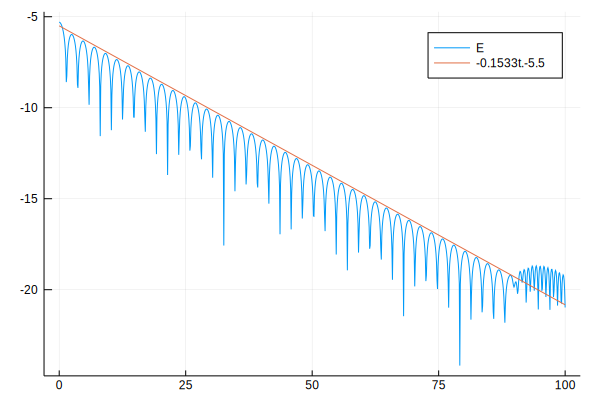

In [31]:
plot( t, nrj; label = "E")
plot!(t, -0.1533*t.-5.50; label="-0.1533t.-5.5")

# Callable type

In [8]:
"""
    Advection(f, p, mesh, v, nv, dt)

Advection type

"""
mutable struct Advection
    
    p        :: Int64 
    mesh     :: UniformMesh
    modes    :: Vector{Float64}
    eig_bspl :: Vector{Float64}
    eigalpha :: Vector{Complex{Float64}}
    
    function Advection( p, mesh )
        nx        = mesh.nx
        modes     = zeros(Float64, nx)
        modes    .= [2π * i / nx for i in 0:nx-1]
        eig_bspl  = zeros(Float64, nx)
        eig_bspl  = zeros(Float64, nx)
        eig_bspl .= bspline(p, -div(p+1,2), 0.0)
        for i in 1:div(p+1,2)-1
            eig_bspl .+= bspline(p, i-(p+1)÷2, 0.0) * 2 .* cos.(i * modes)
        end
        eigalpha  = zeros(Complex{Float64}, nx)
        new( p, mesh, modes, eig_bspl, eigalpha )
    end
    
end

Advection

In [37]:
function (adv :: Advection)(f    :: Array{Complex{Float64},2}, 
                            v    :: Vector{Float64}, 
                            dt   :: Float64)
    
   nx = adv.mesh.nx
   nv = length(v)
   dx = adv.mesh.dx
    
   fft!(f,1)
    
   @simd for j in 1:nv
      @inbounds alpha = dt * v[j] / dx
      # compute eigenvalues of cubic splines evaluated at displaced points
      ishift = floor(-alpha)
      beta   = -ishift - alpha
      fill!(adv.eigalpha,0.0im)
      for i in -div(adv.p-1,2):div(adv.p+1,2)
         adv.eigalpha .+= (bspline(adv.p, i-div(adv.p+1,2), beta) 
                        .* exp.((ishift+i) * 1im .* adv.modes))
      end
          
      # compute interpolating spline using fft and properties of circulant matrices
      
      @inbounds f[:,j] .*= adv.eigalpha ./ adv.eig_bspl
        
   end
        
   ifft!(f,1)
    
end            

In [38]:
function landau_damping_hl(tf::Float64, nt::Int64)
    
  # Set grid
  p = 3
  nx, nv = 128, 256
  xmin, xmax = 0.0, 4π
  vmin, vmax = -6., 6.
  meshx = UniformMesh(xmin, xmax, nx)
  meshv = UniformMesh(vmin, vmax, nv)
  x, v = meshx.x, meshv.x    
  dx = meshx.dx
  
  # Set distribution function for Landau damping
  ϵ, kx = 0.001, 0.5
  f = landau( ϵ, kx, meshx, meshv)
  fᵗ = zeros(Complex{Float64},(nv,nx))
    
  # Instantiate advection functions
  advection_x! = Advection(p, meshx)
  advection_v! = Advection(p, meshv)
  
  # Set time step
  dt = tf / nt
  
  # Run simulation
  ℰ = Float64[]
  
  for it in 1:nt
        
       advection_x!(f, v, 0.5dt)

       ρ = compute_rho(meshv, f)
       e = compute_e(meshx, ρ)
        
       push!(ℰ, 0.5*log(sum(e.*e)*dx))
        
       transpose!(fᵗ, f)
       advection_v!(fᵗ, e, dt)
       transpose!(f, fᵗ)
    
       advection_x!(f, v, 0.5dt)
        
  end
                  
  ℰ

end

landau_damping_hl (generic function with 1 method)

In [39]:
nt = 1000
tf = 100.0
t  = range(0.0, stop=tf, length=nt)
@time nrj = landau_damping_hl(tf, nt);

  9.974339 seconds (1.43 M allocations: 1.843 GiB, 2.86% gc time)


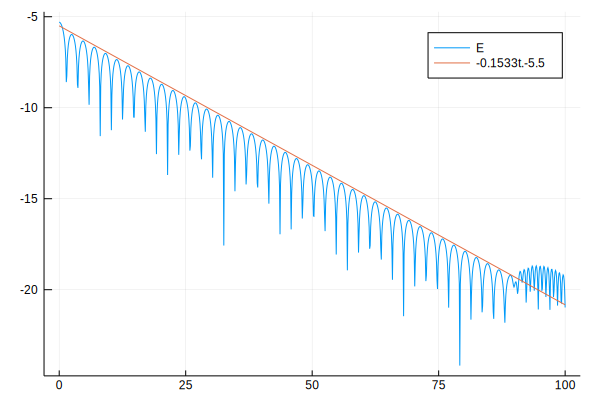

In [40]:
plot( t, nrj; label = "E")
plot!(t, -0.1533*t.-5.50; label="-0.1533t.-5.5")

## Metaprogramming

In [41]:
"""

    @Strang( push_t, push_v )

    Apply the second order Strang splitting

    push_t and push_v are two function calls with
    `dt` as argument.

"""
macro Strang(push_t, push_v)
    return esc(quote
        local full_dt = dt
        dt = 0.5full_dt
        $push_t
        dt = full_dt
        $push_v
        dt = 0.5full_dt
        $push_t
        dt = full_dt
    end)
end

@Strang

In [43]:
function landau_with_macro(tf::Float64, nt::Int64)
    
  # Set grid
  p = 3
  nx, nv = 128, 256
  xmin, xmax = 0.0, 4π
  vmin, vmax = -6., 6.
  meshx = UniformMesh(xmin, xmax, nx)
  meshv = UniformMesh(vmin, vmax, nv)
  x, v = meshx.x, meshv.x    
  dx = meshx.dx
  
  # Set distribution function for Landau damping
  ϵ, kx = 0.001, 0.5
  f  = landau( ϵ, kx, meshx, meshv)
  fᵗ = zeros(Complex{Float64},(nv,nx))
    
  # Instantiate distribution functions
  advection_x! = Advection(p, meshx)
  advection_v! = Advection(p, meshv)
    
  push_t!( f, v, dt ) = advection_x!(f, v, dt)

  function push_v!( f, fᵗ, meshx, meshv, dt, ℰ)
    
      ρ = compute_rho(meshv, f)
      e = compute_e(meshx, ρ)
     
      push!(ℰ, 0.5*log(sum(e.*e)*dx))
     
      transpose!(fᵗ, f)
      advection_v!(fᵗ, e, dt)
      transpose!(f, fᵗ)
    
  end
  
  # Set time step
  dt = tf / nt
  
  # Run simulation
  ℰ = Float64[]
  
  for it in 1:nt
        
       @Strang( push_t!( f, v, dt ),
                push_v!( f, fᵗ, meshx, meshv, dt, ℰ))
        
  end
                  
  ℰ

end

landau_with_macro (generic function with 1 method)

  9.808677 seconds (1.14 M allocations: 1.830 GiB, 2.92% gc time)


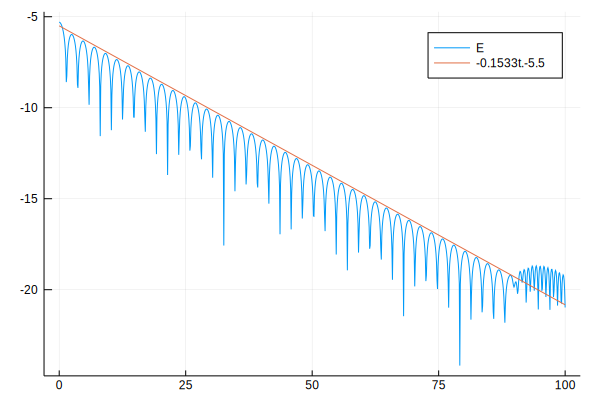

In [44]:
nt = 1000
tf = 100.0
t  = range(0.0, stop=tf, length=nt)
@time nrj = landau_with_macro(tf, nt);
plot( t, nrj; label = "E")
plot!(t, -0.1533*t.-5.50; label="-0.1533t.-5.5")